<img src="blackfriday.png" width=700 height=500>

# Predicting The Amount Of Purchase On Black Friday
##### Minh Truong, Yunhan Bai, David Hook 
### -----------------------------------------------------------------------------------------------------------------------------------------------------------------
## Introduction
For millions of people Black Friday is the time to do some serious Christmas shopping --even before the last of the Thanksgiving leftovers are gone! Black Friday is the Friday after Thanksgiving, and it's one of the major shopping days of the year in the United States, falling anywhere between November 23 and 29. While it's not recognized as an official U.S. holiday, many employees have the day off, except those working in retail.
<br><br>
In this tutorial, our goal is to advertise the right products to the right people. Our strategy is to learn different behaviors of custumers on Black Friday to see what they really like and what they would like to buy on Black Friday. Also, we want is to learn from the past purchases to recognize the pattern and likelihood in a certain group of people in order to increase the profit on Black Friday. Moreover, we would like to know which product categories are purchased the most and by which groups of people has bought the most for that particular product category. Therefore, we can 


# Getting Started with the Data
<br>We make use of Python 3 along with a few imported libraries: <a href="http://pandas.pydata.org/pandas-docs/stable/">pandas</a>, <a href="http://www.numpy.org/">numpy</a>, <a href="https://matplotlib.org/tutorials/index.html">matplotlib</a>, <a href="https://scikit-learn.org/stable/">scikit-learn</a>, <a href="https://seaborn.pydata.org/">seaborn</a>, and more.

In [12]:
# Necessary libraries and imports to complete this tutorial
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f
import seaborn as sns
from sklearn import model_selection
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

# Reading the data

In [13]:
blackfriday = pd.read_csv("blackfriday.csv")
#Making Mean_age so for graphing in later sections
blackfriday['Mean_age'] = blackfriday['Age'].map({'0-17': 8.5, '18-25': 21.5,'26-35': 30.5, '36-45': 40.5,'46-50': 48, '51-55': 53, '55+': 67.5})
#Modify the "Stay_In_Current_City_Years" column, so assume that anyone that live more than 4 years is just 4 years.
blackfriday['Stay_In_Current_City_Years'] = blackfriday['Stay_In_Current_City_Years'].map({'0': 0, '1': 1, '2': 2, '3': 3,'4+': 4})
blackfriday.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Mean_age
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370,8.5
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200,8.5
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422,8.5
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057,8.5
4,1000002,P00285442,M,55+,16,C,4,0,8,NaN,NaN,7969,67.5


In the above dataset, there are 12 columns in total. We have: <br>
Column 1: User_ID <br>
Column 2: Product_ID  <br>
Column 3: Gender (Male and Female) <br>
Column 4: Age (Age in bins) <br>
Column 5: Occupation <br>
Column 6: City_Category (A, B, C) <br>
Column 7: Stay_In_Current_City_Years (Number of years stay in current city) <br>
Column 8: Marital_Status (0 for single, 1 for married) <br>
Column 9: Product_Category_1 <br>
Column 10: Product_Category_2 <br>
Column 11: Product_Category_3 <br>
Column 12: Purchase (Purchase amount in Dollars) <br>
Column 13: Mean_Age (mean of the age bins)<br>
<br>
A product can belong to many different categories.<br>

# Tidying and modifying the data

<b> In tidy data: </b>
<br> 1. Each variable forms a column.
<br> 2. Each observation forms a row.
<br> 3. Each type of observational unit forms a table.

Handling missing data. <br>
As we notice, our missing data is in the product category columns. Therefore, we are going to replace them by 0 to let people know that product does not have different categories. 

In [14]:
blackfriday = blackfriday.fillna(0)
blackfriday.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Mean_age
0,1000001,P00069042,F,0-17,10,A,2,0,3,0.0,0.0,8370,8.5
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200,8.5
2,1000001,P00087842,F,0-17,10,A,2,0,12,0.0,0.0,1422,8.5
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,0.0,1057,8.5
4,1000002,P00285442,M,55+,16,C,4,0,8,0.0,0.0,7969,67.5


Another step in tidying data is to remove variables from column names. <br>In our example, Product_Category_1, Product_Category_2, and Product_Category_3 should be melted to one column. <br>To keep the original dataframe clear and have fewer repeat information, we create a new dataframe to store Product_Category seperately. <br>Item category can be looked up with its Product_ID in the new dataframe.

In [15]:
# Create a seperate dataframe to store category infomation
category_table = blackfriday[['Product_ID', 'Age', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3']]
# Drop Product_Category columns from the original dataframe for neatness
blackfriday = blackfriday.drop(['Product_Category_1','Product_Category_2', 'Product_Category_3'], axis=1)

# Melt Product_Category columns in to one
category_table = pd.melt(category_table, id_vars=['Product_ID'], value_vars=['Product_Category_1', 'Product_Category_2', 'Product_Category_3'])
# Drop any row with value equals to 0 (no category)
category_table = category_table[category_table.value != 0]   
# Drop variable column
category_table = category_table.drop(['variable'], axis=1)
# Rename value column to Product_Category
category_table = category_table.rename(index=str, columns={"value": "Product_Category"})
category_table.head()

,Product_ID,Product_Category
0,P00069042,3.0
1,P00248942,1.0
2,P00087842,12.0
3,P00085442,12.0
4,P00285442,8.0


# Exploratory Data Analysis (EDA)

#### Four types of EDA
- Univariate non-graphical
- Multivariate non-graphical
- Univariate graphical
- Multivariate graphical

#### Advantages of EDA:
- Detection of mistakes
- Checking of assumptions
- Preliminary selection of appropriate models
- Determining relationships among the explanatory variables
- Assessing the direction and rough size of relationships between explanatory and outcome variables

Groups data by age

In [16]:
groups = blackfriday.groupby(['User_ID', 'Age', 'Mean_age']).agg({'Purchase': np.sum}).reset_index()
#0-17
print('group 0-17 total purchase')
display(groups[groups.Mean_age == 8.5].head())
#18-25
print('group 18-25 total purchase')
display(groups[groups.Mean_age == 21.5].head())
#26-35
print('group 26-35 total purchase')
display(groups[groups.Mean_age == 30.5].head())
#36-45
print('group 36-45 total purchase')
display(groups[groups.Mean_age == 40.5].head())
#46-50
print('group 46-50 total purchase')
display(groups[groups.Mean_age == 48].head())
#51-55
print('group 51-55 total purchase')
display(groups[groups.Mean_age == 53].head())
#55+
print('group 55+ total purchase')
display(groups[groups.Mean_age == 67.5].head())

group 0-17 total purchase


,User_ID,Age,Mean_age,Purchase
0,1000001,0-17,8.5,333481
18,1000019,0-17,8.5,1457938
48,1000051,0-17,8.5,200772
72,1000075,0-17,8.5,1035228
83,1000086,0-17,8.5,294050


group 18-25 total purchase


,User_ID,Age,Mean_age,Purchase
17,1000018,18-25,21.5,1978675
20,1000021,18-25,21.5,126744
21,1000022,18-25,21.5,1279678
24,1000025,18-25,21.5,534215
33,1000034,18-25,21.5,807747


group 26-35 total purchase


,User_ID,Age,Mean_age,Purchase
2,1000003,26-35,30.5,341635
4,1000005,26-35,30.5,821001
7,1000008,26-35,30.5,796545
8,1000009,26-35,30.5,593960
10,1000011,26-35,30.5,556902


group 36-45 total purchase


,User_ID,Age,Mean_age,Purchase
6,1000007,36-45,40.5,234427
9,1000010,36-45,40.5,2169486
13,1000014,36-45,40.5,127629
15,1000016,36-45,40.5,150428
22,1000023,36-45,40.5,1670998


group 46-50 total purchase


,User_ID,Age,Mean_age,Purchase
3,1000004,46-50,48.0,205987
12,1000013,46-50,48.0,713927
32,1000033,46-50,48.0,1940043
34,1000035,46-50,48.0,821303
41,1000044,46-50,48.0,1180380


group 51-55 total purchase


,User_ID,Age,Mean_age,Purchase
5,1000006,51-55,53.0,379450
16,1000017,51-55,53.0,1425501
51,1000054,51-55,53.0,187201
56,1000059,51-55,53.0,980068
57,1000060,51-55,53.0,279980


group 55+ total purchase


,User_ID,Age,Mean_age,Purchase
1,1000002,55+,67.5,810353
30,1000031,55+,67.5,496154
77,1000080,55+,67.5,339119
86,1000089,55+,67.5,112226
87,1000090,55+,67.5,1310621


Compute the sum of purchase for a user

In [17]:
total_purchase_of_an_user = blackfriday.groupby('User_ID').agg({'Purchase': np.sum})
total_purchase_of_an_user.reset_index(inplace=True)
total_purchase_of_an_user.head()

,User_ID,Purchase
0,1000001,333481
1,1000002,810353
2,1000003,341635
3,1000004,205987
4,1000005,821001


Compute the sum of a purchase for a product

In [18]:
total_purchase_of_a_product = blackfriday.groupby('Product_ID').agg({'Purchase': np.sum})
total_purchase_of_a_product.reset_index(inplace=True)
total_purchase_of_a_product.head()

,Product_ID,Purchase
0,P00000142,12592163
1,P00000242,3914901
2,P00000342,1261383
3,P00000442,441173
4,P00000542,791219


Compute the frequency of a product that is purchased within a group

In [19]:
freq_purchase =  blackfriday.groupby(['Product_ID']).Product_ID.count().to_frame() # counting the frequency for each product
freq_purchase['Freq'] = freq_purchase.Product_ID #create a new column named "Freq"
freq_purchase = freq_purchase.drop(columns=['Product_ID'], axis=1) 
freq_purchase.reset_index(level=0, inplace=True)
freq_purchase.head()

,Product_ID,Freq
0,P00000142,1130
1,P00000242,371
2,P00000342,238
3,P00000442,92
4,P00000542,146


Merge the two tables: freq_purchase and total_purchase_of_a_product

In [23]:
#Using outer join to merge the two tables together.
freq_purchase = freq_purchase.merge(total_purchase_of_a_product, left_on='Product_ID', right_on='Product_ID', how='outer')
freq_purchase.head()

Product_ID    P00265242
Freq               1858
Purchase_x     13983325
Purchase_y     13983325
Name: 2534, dtype: object

There are several ways to measure purchase frequency on its own. However, we need to measure whether purchase frequency has increased as a result of the community. For this, we can reuse much of the same process to measure changes in spending.

Frequency of purchase is the number of orders placed by a customer over a defined period of time (typically one month or one year). Greater purchase frequently typically implies higher profitability. An online community might encourage people to use the product more and thus purchase more frequently, or use the product more often and have to replace it most often.

# Graphing Frequency Distribution of Purchased Product

Text(0,0.5,'Frequency Purchased')

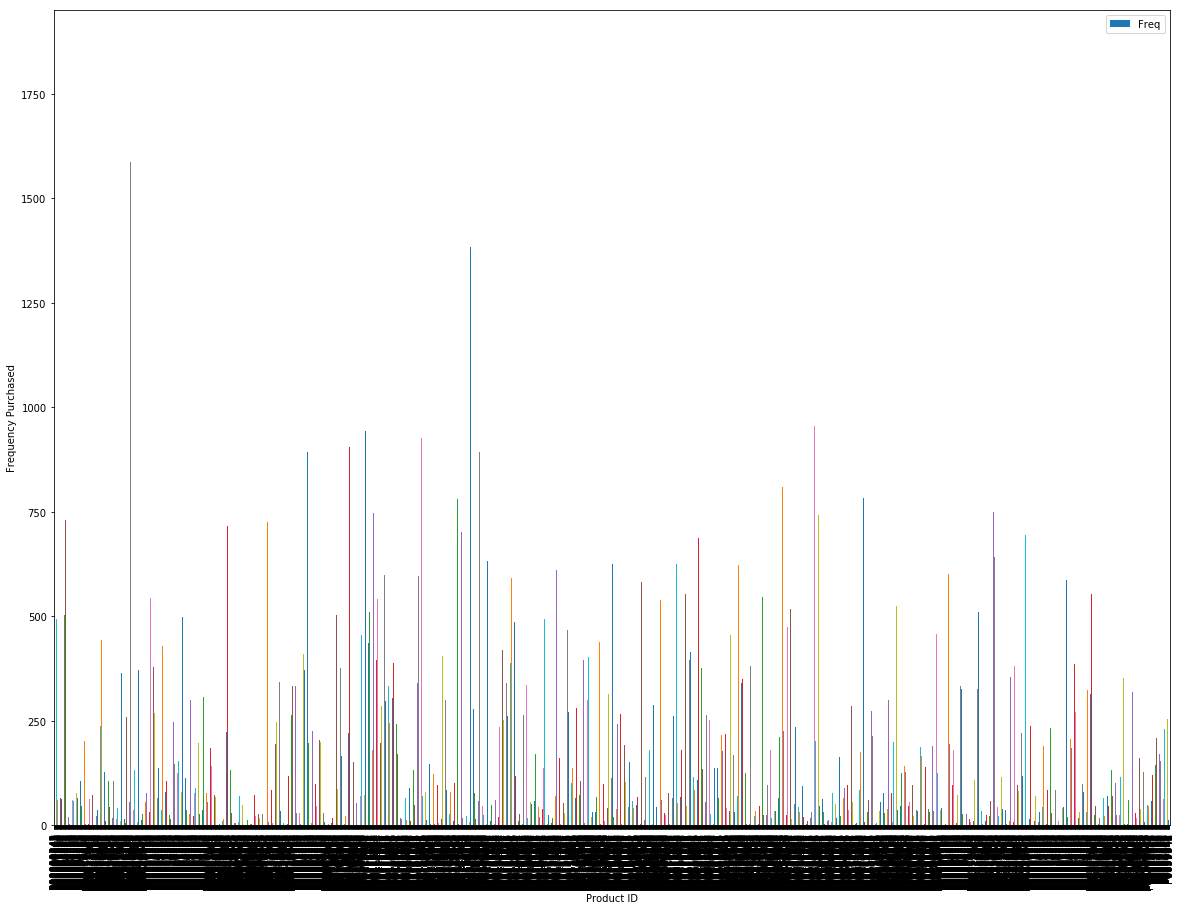

In [22]:
#Using bar plot to describe the frequency of a product is purchased.
ax = freq_purchase.plot.bar(x='Product_ID', y='Freq', figsize=(20, 15))
ax.set_xlabel("Product ID") #Label the x-axis
ax.set_ylabel("Frequency Purchased") #label the y-axis

# Graphing the amount of purchase by different groups of age

Text(0,0.5,'The Amount of Purchase in U.S Dollar')

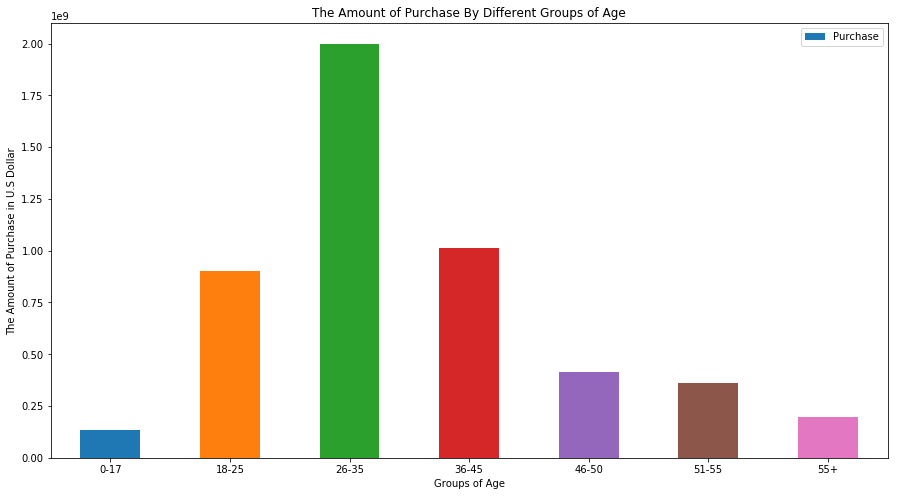

In [12]:
groups = blackfriday.groupby(['Age']).agg({'Purchase': np.sum}).reset_index()
ax = groups.plot.bar(x='Age', y='Purchase', rot=0)
ax.figure.set_size_inches(15, 8)
plt.title("The Amount of Purchase By Different Groups of Age")
plt.xlabel("Groups of Age")
plt.ylabel("The Amount of Purchase in U.S Dollar")

# Graphing the amount of purchase from different city category

Text(0,0.5,'The Amount of Purchase in U.S Dollar')

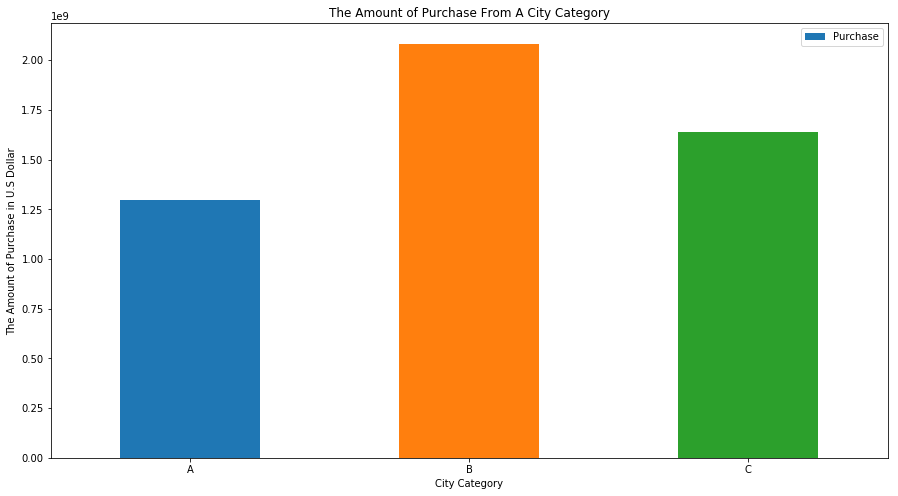

In [13]:
groups = blackfriday.groupby(['City_Category']).agg({'Purchase': np.sum}).reset_index()
ax = groups.plot.bar(x='City_Category', y='Purchase', rot=0)
ax.figure.set_size_inches(15, 8)
plt.title("The Amount of Purchase From A City Category")
plt.xlabel("City Category")
plt.ylabel("The Amount of Purchase in U.S Dollar")

# Graphing Frequency Distribution of Product Categories

Text(0,0.5,'Counts')

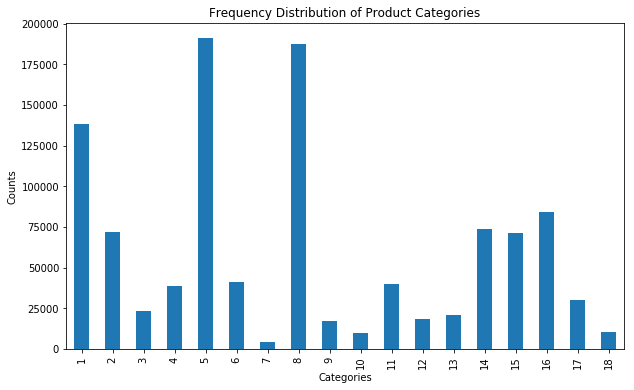

In [14]:
# Create a frequency table of Product_Category from category_table
freq_category = category_table.groupby('Product_Category').count()
freq_category.drop(['Product_ID'], axis=1).reset_index(level=0, inplace=True)
# Plotting the distribution with bar chart
ax=freq_category.plot(kind='bar', legend=False, figsize=(10,6))
ax.set_xticklabels(range(1,19))
ax.set_title("Frequency Distribution of Product Categories")
ax.set_xlabel("Categories")
ax.set_ylabel("Counts")

<h2> Find The Target audiance for best selling Product<h2>

Best selling product

In [24]:
freq_purchase.loc[freq_purchase['Freq'].idxmax()]

Product_ID    P00265242
Freq               1858
Purchase_x     13983325
Purchase_y     13983325
Name: 2534, dtype: object

Say we are an advertising agency. We want to advertise the best selling product in the 
largest consumer city. We can see from our previous graphs that the top selling 
product is P00265242. The top consumer city is city B. 
Our goal is to make an ad that appeals to the largest consumers of product P00265242 in city B.
When making the ad we need to take into account the target age group, the taget gender and the target marital status 

Text(0,0.5,'Amount of Product P00265242 Purchased')

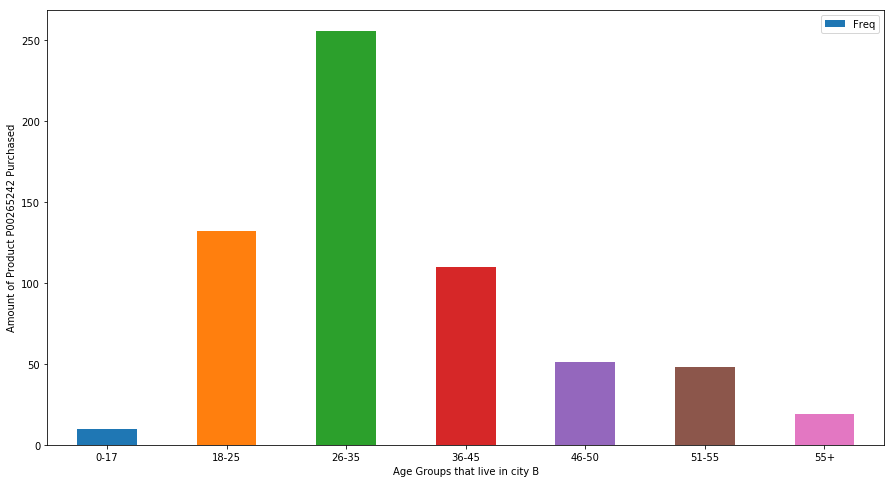

In [52]:
#Highest spending city
city_B = blackfriday.loc[blackfriday["City_Category"] == "B"]
#Most sold product
city_B_best_seller = city_B.loc[city_B['Product_ID']=='P00265242']
#city_b_cat_5 = pd.merge(city_A,catagory_5, on='Product_ID', how='inner')
freq_purchase =  city_B_best_seller.groupby(['Age']).Product_ID.count().to_frame()
freq_purchase['Freq'] = freq_purchase.Product_ID #create a new column named "Freq"
freq_purchase = freq_purchase.drop(columns=['Product_ID'], axis=1) 
freq_purchase.reset_index(level=0, inplace=True)
ax = freq_purchase.plot.bar(x='Age', y='Freq', rot=0)
ax.figure.set_size_inches(15, 8)
plt.xlabel("Age Groups that live in city B")
plt.ylabel("Amount of Product P00265242 Purchased")

Unsuprisingly we can see that the target age group should be ages from 26 to 35. Now lets see how many of our taget
age are male or female.

Text(0,0.5,'Amount of Product P00265242 Purchased')

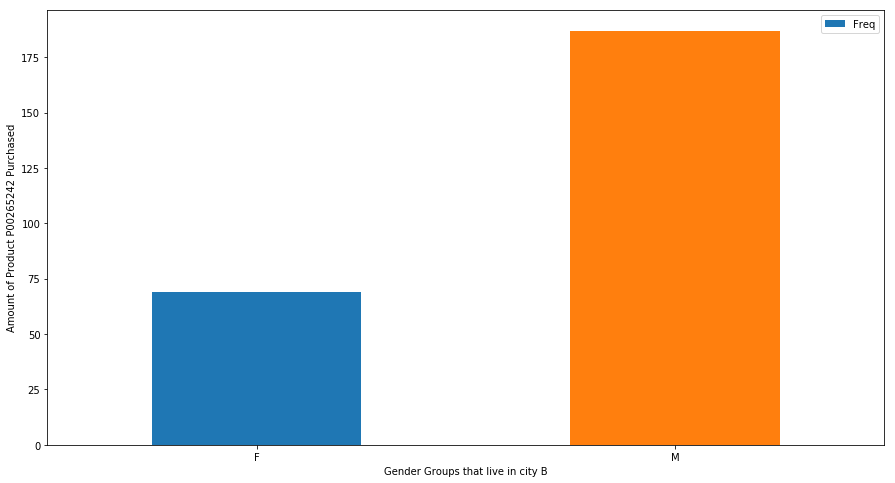

In [54]:
target = city_B_best_seller.loc[city_B_best_seller['Age']=='26-35']
freq_purchase =  target.groupby(['Gender']).Product_ID.count().to_frame()
freq_purchase['Freq'] = freq_purchase.Product_ID #create a new column named "Freq"
freq_purchase = freq_purchase.drop(columns=['Product_ID'], axis=1) 
freq_purchase.reset_index(level=0, inplace=True)
ax = freq_purchase.plot.bar(x='Gender', y='Freq', rot=0)
ax.figure.set_size_inches(15, 8)
plt.xlabel("Gender Groups that live in city B")
plt.ylabel("Amount of Product P00265242 Purchased")

We can now narrow our target group to 26-35 year old men. Lets see if the taget group is single or not

Text(0,0.5,'Amount of Product P00265242 Purchased')

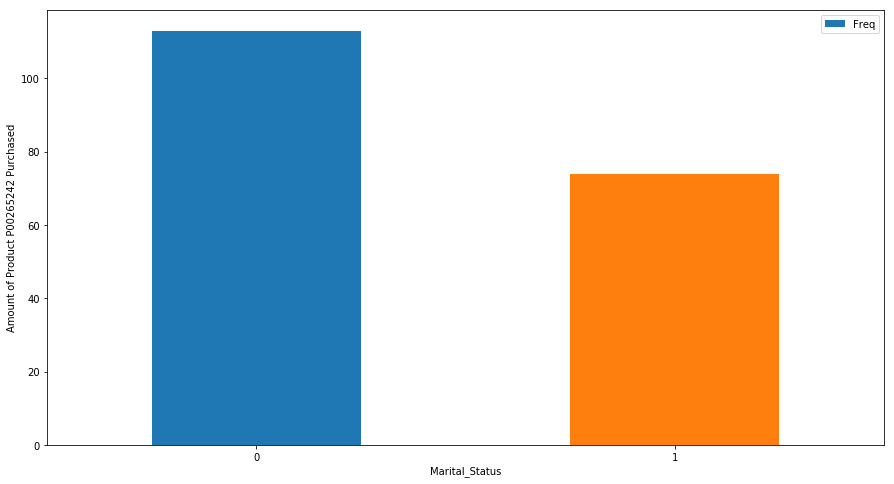

In [57]:
target = target.loc[target['Gender']=='M']
freq_purchase =  target.groupby(['Marital_Status']).Product_ID.count().to_frame()
freq_purchase['Freq'] = freq_purchase.Product_ID #create a new column named "Freq"
freq_purchase = freq_purchase.drop(columns=['Product_ID'], axis=1) 
freq_purchase.reset_index(level=0, inplace=True)
ax = freq_purchase.plot.bar(x='Marital_Status', y='Freq', rot=0)
ax.figure.set_size_inches(15, 8)
plt.xlabel("Marital_Status")
plt.ylabel("Amount of Product P00265242 Purchased")

As an advertising company we should focus on creating an ad that will appeal to single men around the age of 25-36 in 
in city B.

# Doing a graph for an age and the category

# Do hypothesis testing for the mean of different groups of age

# Linear Regression 
Occupation and Age

# Logistic Regression
Male vs Female 
Single vs Married
